In [2]:
import os
import numpy as np
import torch 
import torch.nn.functional as F
import torch.nn as nn
from torch.distributions.normal import Normal
import gymnasium as gym
import matplotlib.pyplot as plt
import json

In [2]:
env = gym.make("BipedalWalker-v3", hardcore=False, render_mode="human",)
def Random_games():
    # Each of these episodes is its own game.
    action_size = env.action_space.shape[0]
    # print(action_size)
    for episode in range(1):
        state = env.reset()
        while True:
            # Render the environment to visualize the walker
            env.render()
            
            # Create a random action in the range [-1.0, 1.0] for each joint
            action = np.random.uniform(-1.0, 1.0, size=action_size)

            # Execute the action in the environment
            next_state, reward, done, truncated, info = env.step(action)

            # Print rewards and action for debugging
            # print(reward, action)
            
            # Check for termination (done or truncated)
            if done or truncated:
                break
                
Random_games()
env.close()


In [3]:
class ReplayBuffer():
    def __init__(self, max_size, input_shape, n_actions):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, *input_shape), dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_shape), dtype=np.float32)
        self.action_memory = np.zeros((self.mem_size, n_actions), dtype=np.float32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool_)


    def store_transition(self, state, action, reward, state_, terminated, truncated):
        index = self.mem_cntr % self.mem_size

        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = terminated or truncated


        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)

        rng = np.random.default_rng()
        batch = rng.choice(max_mem, batch_size, replace=False)
        
        states = self.state_memory[batch]
        states_ = self.new_state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        dones = self.terminal_memory[batch]

        return states, actions, rewards, states_, dones

In [4]:
class CriticNetwork(nn.Module):
    def __init__(self, beta, input_dims, n_actions, fc1_dims=256, fc2_dims=256, name='critic', chkpt_dir='sac'):
        super(CriticNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.name = name

        self.checkpoint_dir = os.path.join(os.getcwd(),chkpt_dir)
        os.makedirs(self.checkpoint_dir, exist_ok=True)
        
        self.checkpoint_file = os.path.join(self.checkpoint_dir, f"{name}_sac.pth")

        self.fc1 = nn.Linear(self.input_dims[0] + n_actions, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.q = nn.Linear(self.fc2_dims, 1)

        self.optimizer = torch.optim.Adam(self.parameters(), lr=beta)
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state, action):
        action_value = self.fc1(torch.cat([state, action], dim=1))
        action_value = F.relu(action_value)
        action_value = self.fc2(action_value)
        action_value = F.relu(action_value)
        q = self.q(action_value)
        return q

    def save_checkpoint(self):
        os.makedirs(self.checkpoint_dir, exist_ok=True)
        torch.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        if os.path.exists(self.checkpoint_file):
            self.load_state_dict(torch.load(self.checkpoint_file))
        else:
            print(f"Checkpoint {self.checkpoint_file} not found!")


class ValueNetwork(nn.Module):
    def __init__(self, beta, input_dims, fc1_dims=256, fc2_dims=256, name='value', chkpt_dir='sac'):
        super(ValueNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.name = name

        self.checkpoint_dir = os.path.join(os.getcwd(),chkpt_dir)
        os.makedirs(self.checkpoint_dir, exist_ok=True)
        self.checkpoint_file = os.path.join(self.checkpoint_dir, f"{name}_sac.pth")
        
        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, fc2_dims)
        self.v = nn.Linear(self.fc2_dims, 1)

        self.optimizer = torch.optim.Adam(self.parameters(), lr=beta)
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)


    def forward(self, state):
        state_value = F.relu(self.fc1(state))
        state_value = F.relu(self.fc2(state_value))
        return self.v(state_value)

    def save_checkpoint(self):
        os.makedirs(self.checkpoint_dir, exist_ok=True)
        torch.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        if os.path.exists(self.checkpoint_file):
            self.load_state_dict(torch.load(self.checkpoint_file))
        else:
            print(f"Checkpoint {self.checkpoint_file} not found!")


class ActorNetwork(nn.Module):
    def __init__(self, alpha, input_dims, max_action, fc1_dims=256, fc2_dims=256, n_actions=4, name='actor', chkpt_dir='sac'):
        super(ActorNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.name = name
        self.max_action = max_action
        self.reparam_noise = torch.finfo(torch.float32).eps

        self.checkpoint_dir = os.path.join(os.getcwd(), chkpt_dir)
        os.makedirs(self.checkpoint_dir, exist_ok=True)

        self.checkpoint_file = os.path.join(self.checkpoint_dir, f"{name}_sac.pth")

        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.mu = nn.Linear(self.fc2_dims, n_actions)
        self.sigma = nn.Linear(self.fc2_dims, n_actions)

        self.optimizer = torch.optim.Adam(self.parameters(), lr=alpha)
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        prob = F.relu(self.fc1(state))
        prob = F.relu(self.fc2(prob))
        mu = self.mu(prob)
        sigma = torch.clamp(self.sigma(prob), min=self.reparam_noise, max=1.0)
        return mu, sigma

    def sample_normal(self, state, reparameterize=True):
        mu, sigma = self.forward(state)
        probabilities = Normal(mu, sigma)

        if reparameterize:
            actions = probabilities.rsample()
        else:
            actions = probabilities.sample()

        action = torch.tanh(actions)*torch.tensor(self.max_action).to(self.device)
        log_probs = probabilities.log_prob(actions)
        log_probs -= torch.log(1-action.pow(2)+self.reparam_noise)
        log_probs = log_probs.sum(1, keepdim=True)

        return action, log_probs



    def save_checkpoint(self):
        os.makedirs(self.checkpoint_dir, exist_ok=True)
        torch.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        if os.path.exists(self.checkpoint_file):
            self.load_state_dict(torch.load(self.checkpoint_file))
        else:
            print(f"Checkpoint {self.checkpoint_file} not found!")


In [5]:
class Agent:
    def __init__(self, alpha=3e-4, beta=3e-4, input_dims=[8],
                 env=None, gamma=0.99, n_actions=4, max_size=500000,
                 tau=0.005, layer1_size=256, layer2_size=256,
                 batch_size=256, reward_scale=5):
        # Discount factor for rewards
        self.gamma = gamma
        
        # Target network soft update factor
        self.tau = tau
        
        # Experience replay buffer
        self.memory = ReplayBuffer(max_size, input_dims, n_actions)
        
        # Batch size for sampling from replay buffer
        self.batch_size = batch_size
        
        # Number of actions in the action space
        self.n_actions = n_actions

        # Initializing actor, critic, and value networks
        self.actor = ActorNetwork(alpha, input_dims, n_actions=n_actions,
                                  name='actor', max_action=env.action_space.high)
        self.critic_1 = CriticNetwork(beta, input_dims, n_actions=n_actions, name='critic_1')
        self.critic_2 = CriticNetwork(beta, input_dims, n_actions=n_actions, name='critic_2')
        self.value = ValueNetwork(beta, input_dims, name='value')
        self.target_value = ValueNetwork(beta, input_dims, name='target_value')

        # Reward scaling factor for improved learning
        self.scale = reward_scale
        
        # Initialize target network parameters
        self.update_network_parameters(tau=1)

    def choose_action(self, observation):
        state = torch.Tensor([observation]).to(self.actor.device)
        actions, _ = self.actor.sample_normal(state, reparameterize=False)
        return actions.cpu().detach().numpy()[0]

    def remember(self, state, action, reward, new_state, terminated, truncated):
        self.memory.store_transition(state, action, reward, new_state, terminated, truncated)

    def update_network_parameters(self, tau=None):
        if tau is None:
            tau = self.tau

        # Soft update target value network parameters
        target_value_params = self.target_value.named_parameters()
        value_params = self.value.named_parameters()

        target_value_state_dict = dict(target_value_params)
        value_state_dict = dict(value_params)

        for name in value_state_dict:
            value_state_dict[name] = tau * value_state_dict[name].clone() + (1 - tau) * target_value_state_dict[name].clone()

        self.target_value.load_state_dict(value_state_dict)

    def save_models(self):
        print('.... saving models ....')
        self.actor.save_checkpoint()
        self.value.save_checkpoint()
        self.target_value.save_checkpoint()
        self.critic_1.save_checkpoint()
        self.critic_2.save_checkpoint()

    def load_models(self):
        print('.... loading models ....')
        self.actor.load_checkpoint()
        self.value.load_checkpoint()
        self.target_value.load_checkpoint()
        self.critic_1.load_checkpoint()
        self.critic_2.load_checkpoint()

    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return

        # Sample a batch from replay buffer
        state, action, reward, new_state, done = self.memory.sample_buffer(self.batch_size)

        reward = torch.tensor(reward, dtype=torch.float).to(self.actor.device)
        done = torch.tensor(done).to(self.actor.device)
        state_ = torch.tensor(new_state, dtype=torch.float).to(self.actor.device)
        state = torch.tensor(state, dtype=torch.float).to(self.actor.device)
        action = torch.tensor(action, dtype=torch.float).to(self.actor.device)

        # Value network loss and optimization
        value = self.value(state).view(-1)
        value_ = self.target_value(state_).view(-1)
        value_[done] = 0.0

        actions, log_probs = self.actor.sample_normal(state, reparameterize=False)
        log_probs = log_probs.view(-1)
        q1_new_policy = self.critic_1(state, actions)
        q2_new_policy = self.critic_2(state, actions)
        critic_value = torch.min(q1_new_policy, q2_new_policy).view(-1)

        self.value.optimizer.zero_grad()
        value_target = critic_value - log_probs
        value_loss = 0.5 * F.mse_loss(value, value_target)
        value_loss.backward(retain_graph=True)
        self.value.optimizer.step()

        # Actor network loss and optimization
        actions, log_probs = self.actor.sample_normal(state, reparameterize=True)
        log_probs = log_probs.view(-1)
        q1_new_policy = self.critic_1(state, actions)
        q2_new_policy = self.critic_2(state, actions)
        critic_value = torch.min(q1_new_policy, q2_new_policy).view(-1)

        actor_loss = log_probs - critic_value
        actor_loss = torch.mean(actor_loss)
        self.actor.optimizer.zero_grad()
        actor_loss.backward(retain_graph=True)
        self.actor.optimizer.step()

        # Critic network loss and optimization
        self.critic_1.optimizer.zero_grad()
        self.critic_2.optimizer.zero_grad()
        q_hat = self.scale * reward + self.gamma * value_
        q1_old_policy = self.critic_1(state, action).view(-1)
        q2_old_policy = self.critic_2(state, action).view(-1)
        critic_1_loss = 0.5 * F.mse_loss(q1_old_policy, q_hat)
        critic_2_loss = 0.5 * F.mse_loss(q2_old_policy, q_hat)

        critic_loss = critic_1_loss + critic_2_loss
        critic_loss.backward()
        self.critic_1.optimizer.step()
        self.critic_2.optimizer.step()

        # Update target value network parameters
        self.update_network_parameters()

In [7]:
def plot_learning_curve_moving_avg(x, scores, figure_file):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg)
    plt.title('Running average of previous 100 scores')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.grid()
    plt.savefig(figure_file)
    plt.show()
    

def plot_learning_curve(episodes, scores, figure_file):
    plt.figure(figsize=(10, 6))
    plt.plot(episodes, scores)
    plt.title('Learning Curve')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.grid(True)
    plt.savefig(figure_file)
    plt.close()

def change_agent_dir(agent,dir):

    agent.actor.checkpoint_dir = dir
    agent.actor.checkpoint_file = os.path.join(dir, f"{agent.actor.name}_sac.pth")

    agent.critic_1.checkpoint_dir = dir
    agent.critic_1.checkpoint_file = os.path.join(dir, f"{agent.critic_1.name}_sac.pth")

    agent.critic_2.checkpoint_dir = dir
    agent.critic_2.checkpoint_file = os.path.join(dir, f"{agent.critic_2.name}_sac.pth")

    agent.value.checkpoint_dir = dir
    agent.value.checkpoint_file = os.path.join(dir, f"{agent.value.name}_sac.pth")

    agent.target_value.checkpoint_dir = dir
    agent.target_value.checkpoint_file = os.path.join(dir, f"{agent.target_value.name}_sac.pth")

    return agent

In [ ]:
# def plot_learning_curve(x, scores, figure_file):
#     running_avg = np.zeros(len(scores))
#     for i in range(len(running_avg)):
#         running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
#     plt.plot(x, running_avg)
#     plt.title('Running average of previous 100 scores')
#     plt.xlabel('Episode')
#     plt.ylabel('Score')
#     plt.grid()
#     plt.savefig(figure_file)
#     plt.show()
    
# if __name__ == '__main__':
#     env = gym.make("BipedalWalker-v3", hardcore=False, render_mode="rgb_array")
#     # print(*env.observation_space.shape)
#     agent = Agent(input_dims=env.observation_space.shape, env=env,
#                   n_actions=env.action_space.shape[0])
#     episodes = 2000
#     n = 500

#     figure_dir = os.path.join(os.getcwd(), 'plots')
#     os.makedirs(figure_dir, exist_ok=True)
#     figure_file = os.path.join(figure_dir, 'Bipedal_Walker.png')

#     best_score = -float('inf')  # Initialize to a very low value
#     score_history = []
#     load_checkpoint = False

#     if load_checkpoint == True:
#         env = gym.make("BipedalWalker-v3", hardcore=False, render_mode="human")
#     else:
#         env = gym.make("BipedalWalker-v3", hardcore=False, render_mode="rgb_array")


#     if load_checkpoint:
#         agent.load_models()
#         env.reset()
#         env.render()

#     for i in range(episodes):
#         observation,_ = env.reset()
#         terminated = False
#         truncated = False
#         score = 0
#         while not terminated and not truncated:
#             action = agent.choose_action(observation)
#             # print(action)
#             observation_, reward, terminated, truncated, info = env.step(action)
#             score += reward
#             agent.remember(observation, action, reward, observation_, terminated, truncated)
#             if not load_checkpoint:
#                 agent.learn()
#             observation = observation_
#         score_history.append(score)
#         avg_score = np.mean(score_history[-100:])

#         if avg_score > best_score:
#             best_score = avg_score
#             if not load_checkpoint:

#                 dir = os.path.join(os.getcwd(), 'sac')

#                 agent = change_agent_dir(agent,dir)
#                 agent.save_models()

#         print(f'Episode {i}, Score: {score:.1f}, Avg Score: {avg_score:.1f}, Best Score: {best_score:.1f}, Terminated: {terminated}, Truncated: {truncated}')

#         if(i % n == 0):

#             dir = os.path.join(os.getcwd(), f'sac_{i}')

#             agent = change_agent_dir(agent,dir)
#             agent.save_models()

#     if not load_checkpoint:
#         x = [i+1 for i in range(episodes)]
#         plot_learning_curve(x, score_history, figure_file)

ValueError: too many values to unpack (expected 2)

C:\Users\sreeh\AppData\Local\Temp\ipykernel_31240\1787489091.py:36: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  state = torch.Tensor([observation]).to(self.actor.device)


.... saving models ....
Episode 0, Score: -112.1, Avg Score: -112.1, Best Score: -112.1, Steps: 84, Terminated: True, Truncated: False
.... saving models ....
.... saving models ....
Episode 1, Score: -111.6, Avg Score: -111.9, Best Score: -111.9, Steps: 72, Terminated: True, Truncated: False
.... saving models ....
Episode 2, Score: -111.5, Avg Score: -111.8, Best Score: -111.8, Steps: 71, Terminated: True, Truncated: False
.... saving models ....
Episode 3, Score: -103.2, Avg Score: -109.6, Best Score: -109.6, Steps: 232, Terminated: True, Truncated: False
Episode 4, Score: -114.0, Avg Score: -110.5, Best Score: -109.6, Steps: 73, Terminated: True, Truncated: False
Episode 5, Score: -112.8, Avg Score: -110.9, Best Score: -109.6, Steps: 56, Terminated: True, Truncated: False
Episode 6, Score: -118.8, Avg Score: -112.0, Best Score: -109.6, Steps: 61, Terminated: True, Truncated: False
Episode 7, Score: -144.4, Avg Score: -116.1, Best Score: -109.6, Steps: 580, Terminated: True, Truncat

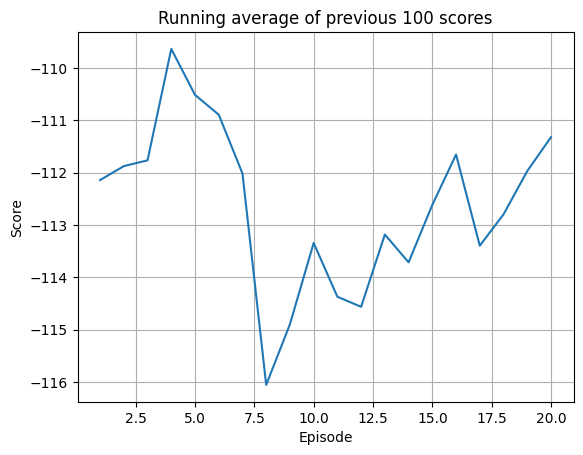

In [8]:
if __name__ == '__main__':
    env = gym.make("BipedalWalker-v3", hardcore=False, render_mode="rgb_array")
    agent = Agent(input_dims=env.observation_space.shape, env=env,
                  n_actions=env.action_space.shape[0])
    
    episodes = 20
    n = 10

    figure_dir = os.path.join(os.getcwd(), 'plots')
    os.makedirs(figure_dir, exist_ok=True)
    figure_file = os.path.join(figure_dir, 'Bipedal_Walker_Learning_Curve.png')
    figure_file_moving_avg = os.path.join(figure_dir, 'Bipedal_Walker_Learning_Curve_Moving_Avg.png')

    best_score = -float('inf')
    score_history = []
    episode_lengths = []
    rewards_history = []
    load_checkpoint = False

    if load_checkpoint:
        env = gym.make("BipedalWalker-v3", hardcore=False, render_mode="human")
        agent.load_models()
    else:
        env = gym.make("BipedalWalker-v3", hardcore=False, render_mode="rgb_array")

    for i in range(episodes):
        observation, _ = env.reset()
        terminated = False
        truncated = False
        score = 0
        episode_reward = []
        step = 0

        while not terminated and not truncated:
            action = agent.choose_action(observation)
            observation_, reward, terminated, truncated, info = env.step(action)
            score += reward
            episode_reward.append(float(reward))
            agent.remember(observation, action, reward, observation_, terminated, truncated)
            if not load_checkpoint:
                agent.learn()
            observation = observation_
            step += 1

        score_history.append(score)
        episode_lengths.append(step)
        rewards_history.append(episode_reward)
        avg_score = np.mean(score_history[-100:])

        if avg_score > best_score:
            best_score = avg_score
            if not load_checkpoint:
                dir = os.path.join(os.getcwd(), 'sac')
                agent = change_agent_dir(agent, dir)
                agent.save_models()

        print(f'Episode {i}, Score: {score:.1f}, Avg Score: {avg_score:.1f}, Best Score: {best_score:.1f}, Steps: {step}, Terminated: {terminated}, Truncated: {truncated}')

        if (i % n == 0):
            dir = os.path.join(os.getcwd(), f'sac_{i}')
            agent = change_agent_dir(agent, dir)
            agent.save_models()

    if not load_checkpoint:
        episodes_list = list(range(1, episodes + 1))
        plot_learning_curve(episodes_list, score_history, figure_file)
        plot_learning_curve_moving_avg(episodes_list, score_history, figure_file_moving_avg)

    # Save collected data for further analysis
    np.save('score_history.npy', np.array(score_history))
    np.save('episode_lengths.npy', np.array(episode_lengths))
    
    # Save rewards_history as a JSON file
    with open('rewards_history.json', 'w') as f:
        json.dump(rewards_history, f)

    # Save summary statistics of rewards
    rewards_summary = {
        'mean': np.mean([np.mean(episode_rewards) for episode_rewards in rewards_history]),
        'std': np.std([np.mean(episode_rewards) for episode_rewards in rewards_history]),
        'min': np.min([np.min(episode_rewards) for episode_rewards in rewards_history]),
        'max': np.max([np.max(episode_rewards) for episode_rewards in rewards_history])
    }
    np.save('rewards_summary.npy', rewards_summary)

In [23]:
if __name__ == '__main__':
    env = gym.make("BipedalWalker-v3", hardcore=False, render_mode="rgb_array")
    agent = Agent(input_dims=env.observation_space.shape, env=env,
                  n_actions=env.action_space.shape[0])
    
    episodes = 2001
    n = 1000

    best_score = -float('inf')
    score_history = []
    episode_lengths = []
    rewards_history = []

    for i in range(episodes):
        observation, _ = env.reset()
        terminated = False
        truncated = False
        score = 0
        episode_reward = []
        step = 0

        while not terminated and not truncated:
            action = agent.choose_action(observation)
            observation_, reward, terminated, truncated, info = env.step(action)
            score += reward
            episode_reward.append(float(reward))
            agent.remember(observation, action, reward, observation_, terminated, truncated)
            agent.learn()
            observation = observation_
            step += 1

        score_history.append(score)
        episode_lengths.append(step)
        rewards_history.append(episode_reward)
        avg_score = np.mean(score_history[-100:])

        if avg_score > best_score:
            best_score = avg_score
            dir = os.path.join(os.getcwd(), 'sac')
            agent = change_agent_dir(agent, dir)
            agent.save_models()

        print(f'Episode {i}, Score: {score:.1f}, Avg Score: {avg_score:.1f}, Best Score: {best_score:.1f}, Steps: {step}, Terminated: {terminated}, Truncated: {truncated}')

        if (i % n == 0):
            dir = os.path.join(os.getcwd(), f'sac_{i}')
            agent = change_agent_dir(agent, dir)
            agent.save_models()

    # Save collected data for further analysis
    np.save('score_history.npy', np.array(score_history))
    np.save('episode_lengths.npy', np.array(episode_lengths))
    
    with open('rewards_history.json', 'w') as f:
        json.dump(rewards_history, f)


.... saving models ....
Episode 0, Score: -92.9, Avg Score: -92.9, Best Score: -92.9, Steps: 95, Terminated: True, Truncated: False
.... saving models ....
.... saving models ....
Episode 1, Score: -92.9, Avg Score: -92.9, Best Score: -92.9, Steps: 110, Terminated: True, Truncated: False
Episode 2, Score: -95.0, Avg Score: -93.6, Best Score: -92.9, Steps: 113, Terminated: True, Truncated: False
Episode 3, Score: -103.4, Avg Score: -96.1, Best Score: -92.9, Steps: 74, Terminated: True, Truncated: False
Episode 4, Score: -151.4, Avg Score: -107.1, Best Score: -92.9, Steps: 609, Terminated: True, Truncated: False
Episode 5, Score: -126.8, Avg Score: -110.4, Best Score: -92.9, Steps: 105, Terminated: True, Truncated: False
Episode 6, Score: -119.7, Avg Score: -111.7, Best Score: -92.9, Steps: 115, Terminated: True, Truncated: False
Episode 7, Score: -120.7, Avg Score: -112.9, Best Score: -92.9, Steps: 66, Terminated: True, Truncated: False
Episode 8, Score: -125.9, Avg Score: -114.3, Best 

In [25]:
if __name__ == '__main__':
    # Load the saved data
    score_history = np.load('score_history.npy')
    episode_lengths = np.load('episode_lengths.npy')
    with open('rewards_history.json', 'r') as f:
        rewards_history = json.load(f)

    episodes = len(score_history)
    episodes_list = list(range(1, episodes + 1))

    # Create plots directory
    figure_dir = os.path.join(os.getcwd(), 'plots')
    os.makedirs(figure_dir, exist_ok=True)

    # Generate and save plots
    figure_file = os.path.join(figure_dir, 'Bipedal_Walker_Learning_Curve.png')
    figure_file_moving_avg = os.path.join(figure_dir, 'Bipedal_Walker_Learning_Curve_Moving_Avg.png')

In [26]:
plot_learning_curve(episodes_list, score_history, figure_file)

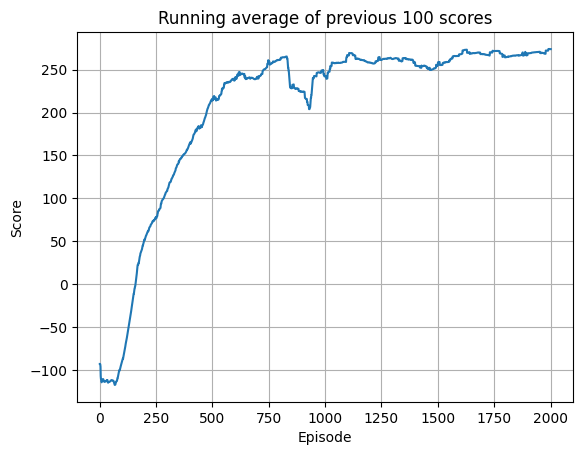

In [27]:
plot_learning_curve_moving_avg(episodes_list, score_history, figure_file_moving_avg)

In [30]:
if __name__ == '__main__':
    env = gym.make("BipedalWalker-v3", hardcore=False, render_mode="rgb_array")
    video_save_dir = os.path.join(os.getcwd(), 'videos')
    env = gym.wrappers.RecordVideo(env, video_save_dir, episode_trigger=lambda e: e == 0)  # Save only the first episode
    
    agent = Agent(input_dims=env.observation_space.shape, env=env,
                  n_actions=env.action_space.shape[0])

    # Load the best model
    dir = os.path.join(os.getcwd(), 'sac')
    agent = change_agent_dir(agent, dir)
    agent.load_models()

    num_test_episodes = 5
    for episode in range(num_test_episodes):
        observation, _ = env.reset()
        terminated = False
        truncated = False
        total_reward = 0
        steps = 0

        while not terminated and not truncated:
            action = agent.choose_action(observation)
            observation_, reward, terminated, truncated, info = env.step(action)
            total_reward += reward
            observation = observation_
            steps += 1
            env.render()

        print(f"Test Episode {episode + 1}: Total Reward: {total_reward:.2f}, Steps: {steps}")

    env.close()
    print(f"Video saved in {video_save_dir}")


d:\Work\.venv\Lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at d:\Work\RL\Project\SAC_own\videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


.... loading models ....


C:\Users\sreeh\AppData\Local\Temp\ipykernel_31240\679229798.py:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(self.checkpoint_file))
C:\U

Test Episode 1: Total Reward: 275.62, Steps: 1536
Test Episode 2: Total Reward: 281.71, Steps: 1447
Test Episode 3: Total Reward: 274.36, Steps: 1575
Test Episode 4: Total Reward: 281.64, Steps: 1429
Test Episode 5: Total Reward: 273.22, Steps: 1575
Video saved in d:\Work\RL\Project\SAC_own\videos


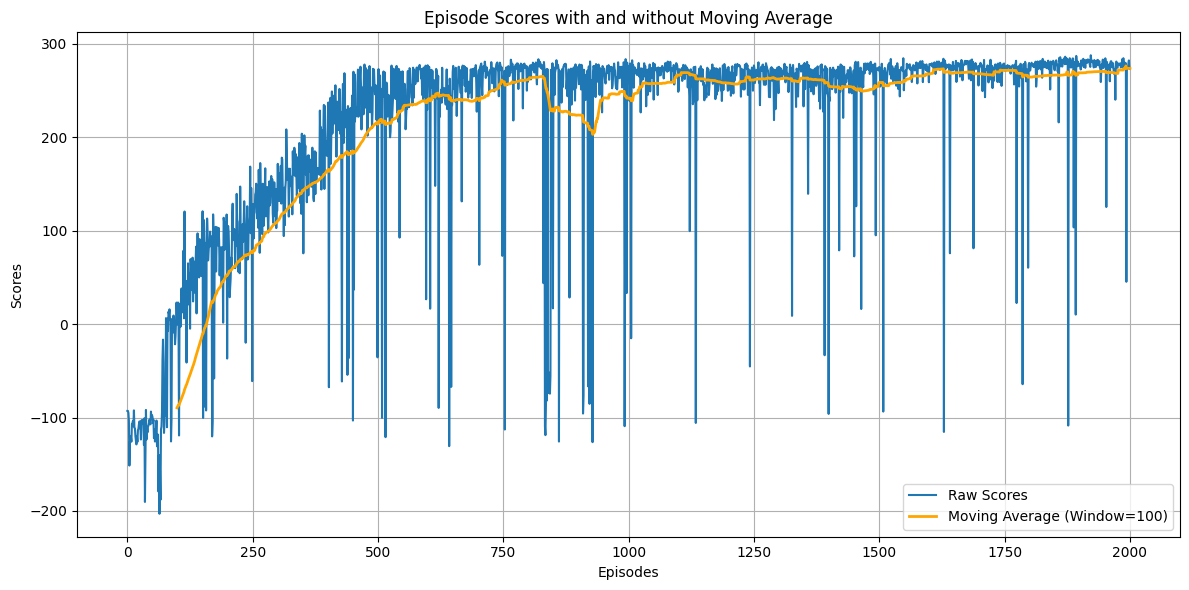

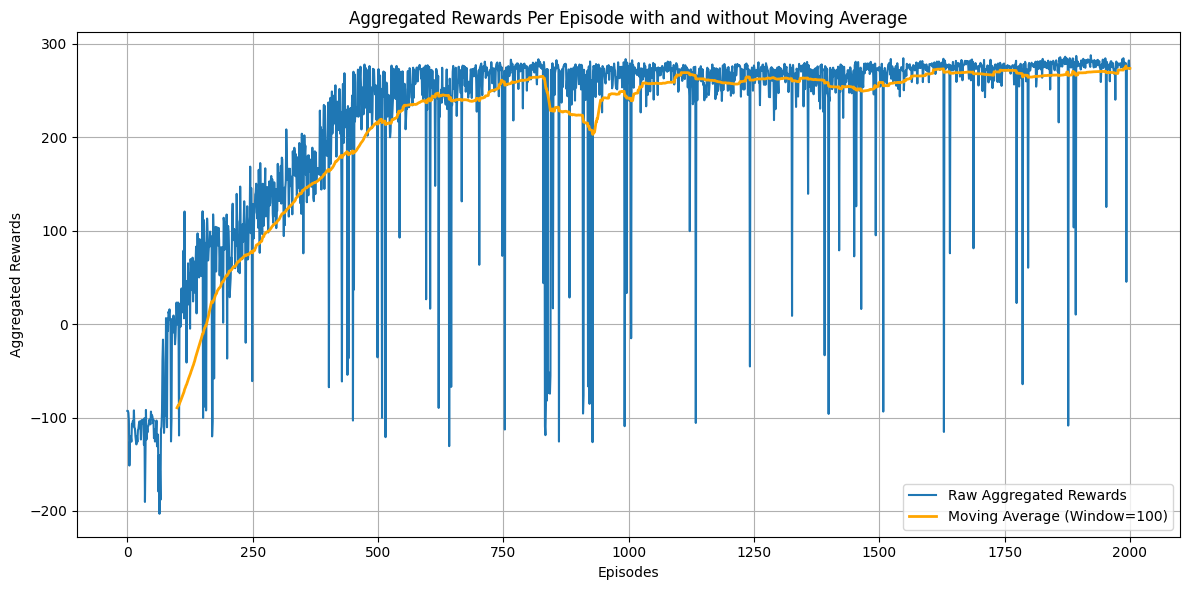

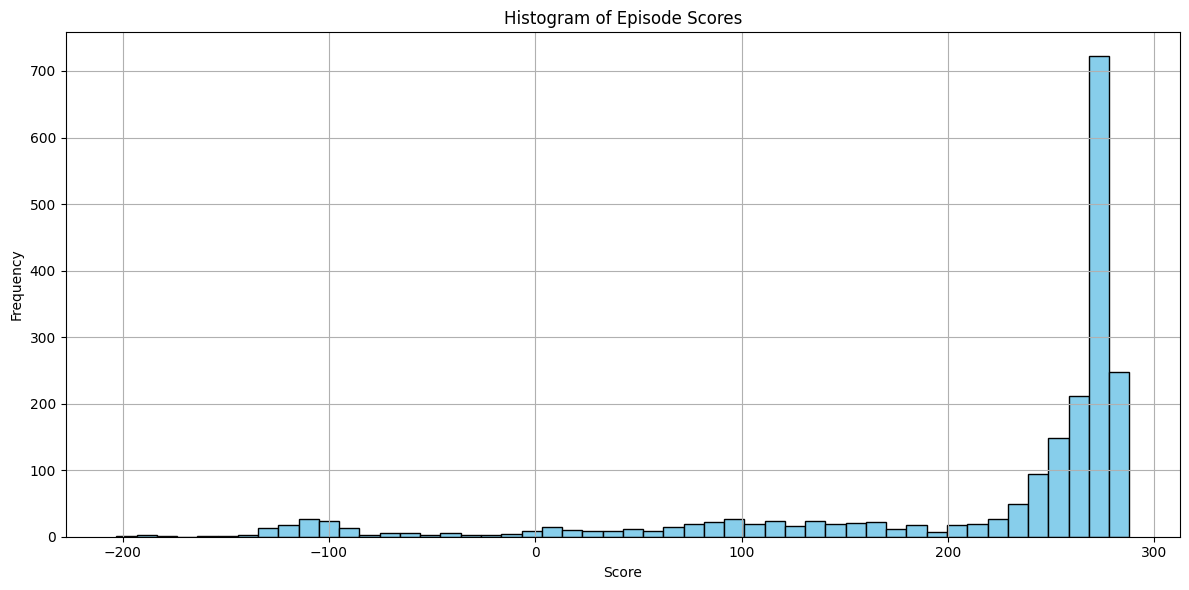

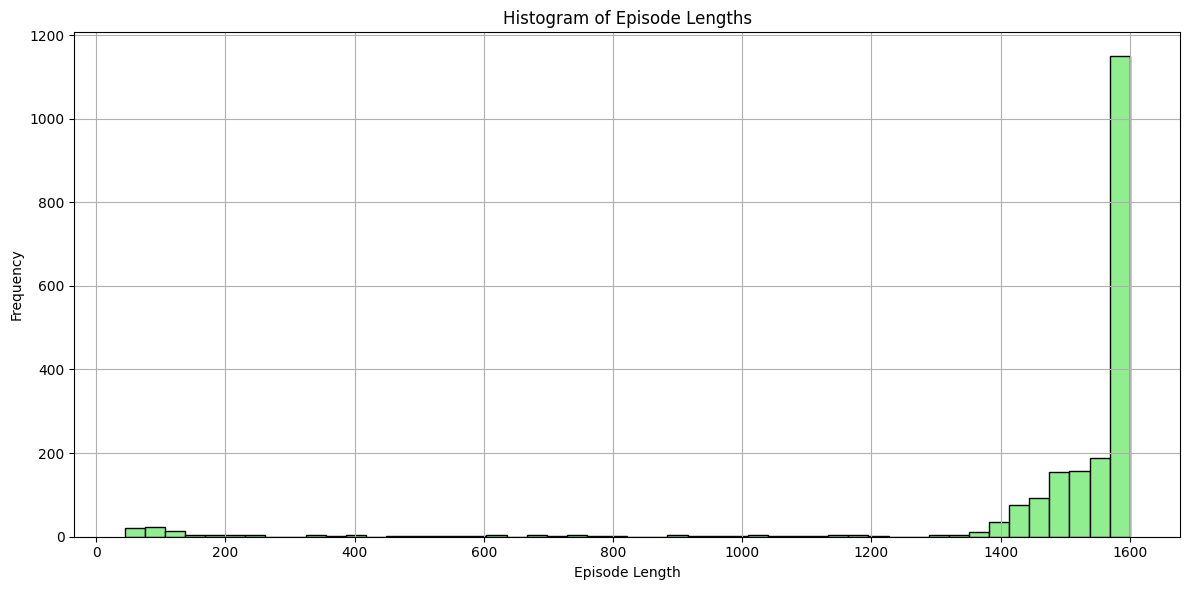

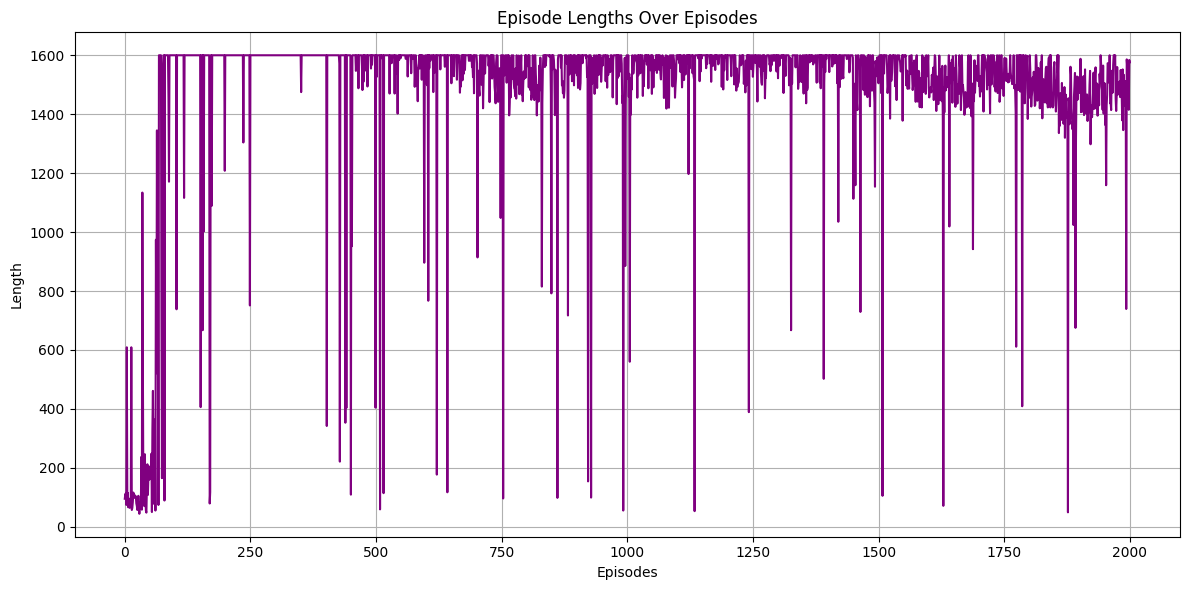

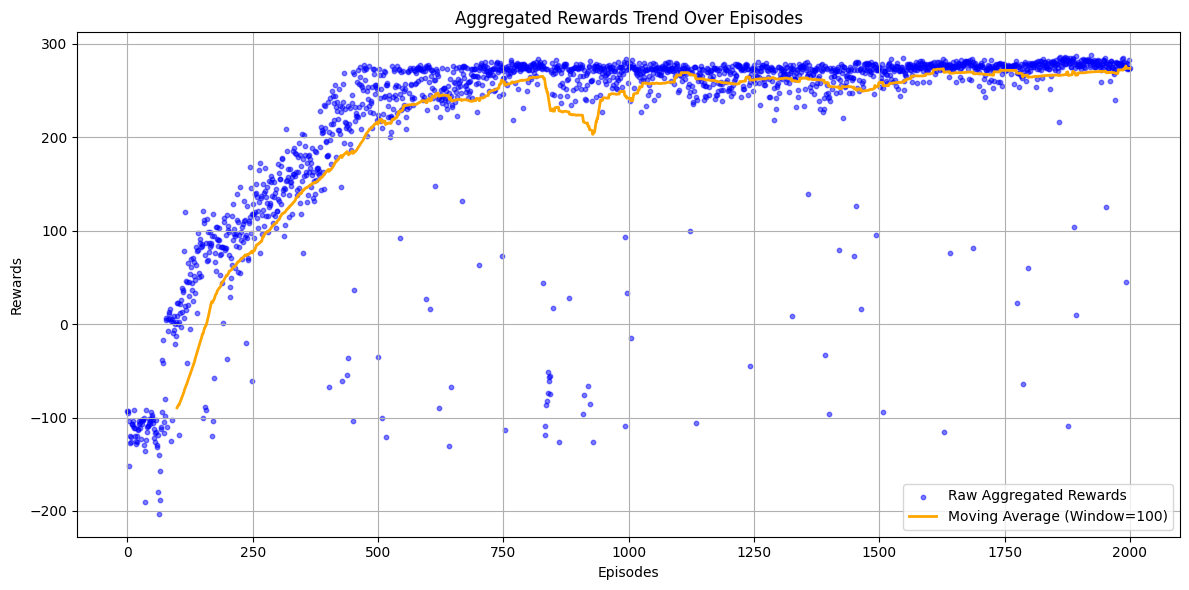

Plots generated and saved to 'plots' directory.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import json
import os

# Load data
score_history = np.load('score_history.npy')
episode_lengths = np.load('episode_lengths.npy')

# Load rewards history (per step, per episode)
with open('rewards_history.json', 'r') as f:
    rewards_history = json.load(f)

# Aggregate episode rewards
aggregated_rewards = [sum(episode_rewards) for episode_rewards in rewards_history]

# Moving average filter
def moving_average(data, window_size=100):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Apply moving average filter
window_size = 100
smoothed_scores = moving_average(score_history, window_size)
smoothed_rewards = moving_average(aggregated_rewards, window_size)

# Plot raw scores and smoothed scores
plt.figure(figsize=(12, 6))
plt.plot(score_history, label='Raw Scores')
plt.plot(range(window_size - 1, len(score_history)), smoothed_scores, label=f'Moving Average (Window={window_size})', color='orange', linewidth=2)
plt.title('Episode Scores with and without Moving Average')
plt.xlabel('Episodes')
plt.ylabel('Scores')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('plots/scores_with_moving_average.png')
plt.show()

# Plot aggregated rewards with moving average
plt.figure(figsize=(12, 6))
plt.plot(aggregated_rewards, label='Raw Aggregated Rewards')
plt.plot(range(window_size - 1, len(aggregated_rewards)), smoothed_rewards, label=f'Moving Average (Window={window_size})', color='orange', linewidth=2)
plt.title('Aggregated Rewards Per Episode with and without Moving Average')
plt.xlabel('Episodes')
plt.ylabel('Aggregated Rewards')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('plots/rewards_with_moving_average.png')
plt.show()

# Plot histogram of episode scores
plt.figure(figsize=(12, 6))
plt.hist(score_history, bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Episode Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.grid()
plt.tight_layout()
plt.savefig('plots/score_histogram.png')
plt.show()

# Plot histogram of episode lengths
plt.figure(figsize=(12, 6))
plt.hist(episode_lengths, bins=50, color='lightgreen', edgecolor='black')
plt.title('Histogram of Episode Lengths')
plt.xlabel('Episode Length')
plt.ylabel('Frequency')
plt.grid()
plt.tight_layout()
plt.savefig('plots/length_histogram.png')
plt.show()

# Plot episode lengths over episodes
plt.figure(figsize=(12, 6))
plt.plot(episode_lengths, label='Episode Lengths', color='purple')
plt.title('Episode Lengths Over Episodes')
plt.xlabel('Episodes')
plt.ylabel('Length')
plt.grid()
plt.tight_layout()
plt.savefig('plots/episode_lengths_over_time.png')
plt.show()

# Reward trend over episodes (scatter plot)
plt.figure(figsize=(12, 6))
plt.scatter(range(len(aggregated_rewards)), aggregated_rewards, s=10, color='blue', alpha=0.5, label='Raw Aggregated Rewards')
plt.plot(range(window_size - 1, len(aggregated_rewards)), smoothed_rewards, label=f'Moving Average (Window={window_size})', color='orange', linewidth=2)
plt.title('Aggregated Rewards Trend Over Episodes')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('plots/aggregated_rewards_trend.png')
plt.show()

# Save summary statistics
summary_stats = {
    "mean_score": np.mean(score_history),
    "std_score": np.std(score_history),
    "min_score": np.min(score_history),
    "max_score": np.max(score_history),
    "mean_episode_length": np.mean(episode_lengths),
    "std_episode_length": np.std(episode_lengths),
    "min_episode_length": np.min(episode_lengths),
    "max_episode_length": np.max(episode_lengths)
}

# Save the summary statistics to a text file
os.makedirs('plots', exist_ok=True)
with open('plots/summary_statistics.txt', 'w') as f:
    for key, value in summary_stats.items():
        f.write(f"{key}: {value}\n")

print("Plots generated and saved to 'plots' directory.")
